## Final Project 


With the data cleaned in the previous Notebook we explore the variables more significant.  First we check for collinearity using a heatmap matrix, eliminating the collinear variables for the analysis.  Then we scale the data, and transformed it with Log function.  After that we split our data into training and testing data sets.  We train the model and evaluate with Linear Regression, Ridge Regression, Lasso Regression obtaining similar results and using R2 and MSE to assess the model.  We save the model for use it in a flask simulation.


In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import pickle

In [3]:
# Read our Data file 
data = pd.read_csv('DATA_FINAL.csv')

#Specify a file name to export the model
filename='Regressor_model.sav'  

In [4]:
data.head()

,Consecutivo,id,neighbourhood_b,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,...,Long_term_stays_allowed,Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s),Private_entrance,Self_check-in,Smoking_allowed,"Step-free access/wheelchair accessible, or anything containing 'accessible'",Suitable_for_events,Unnamed: 27,total_paid_amount,host_days_active
0,1,14714,Juarez,Apartment,Private room,2,1.0,1,1,478,...,1,0,0,0,1,0,0,NaN,765,3497
1,2,22787,San Rafael,Hotel,Private room,2,1.0,1,1,1969,...,0,0,0,1,0,0,0,NaN,1969,3400
2,5,44616,Condesa,Hotel,Private room,16,9.0,9,1,1893,...,0,0,0,0,0,0,0,NaN,1893,3241
3,6,58955,Roma Norte,Apartment,Entire home/apt,2,1.5,1,1,1625,...,0,0,0,0,0,1,0,NaN,2103,3149
4,7,61792,Condesa,House,Private room,2,1.0,1,1,956,...,0,0,0,1,0,0,0,NaN,1243,3132


In [5]:
#Drop columns that we are not going to use
to_drop = ['host_since',
           'Consecutivo',
           'Unnamed: 27', 
           'total_paid_amount']
to_drop.extend(list(data.columns[data.columns.str.endswith('nan')]))

data.drop(to_drop, axis=1, inplace=True)

In [6]:
# Convert Categorical values in a new Data frame
transformed_df = pd.get_dummies(data)

In [7]:
transformed_df.head()

,id,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,minimum_nights,availability_30,number_of_reviews,...,neighbourhood_b_Zona Rosa,property_type_Apartment,property_type_Hotel,property_type_House,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,14714,2,1.0,1,1,478,287,2,15,0,...,0,1,0,0,0,1,0,0,0,1
1,22787,2,1.0,1,1,1969,0,1,20,57,...,0,0,1,0,0,1,0,0,0,1
2,44616,16,9.0,9,1,1893,0,1,12,39,...,0,0,1,0,0,1,0,0,0,1
3,58955,2,1.5,1,1,1625,478,3,28,39,...,0,1,0,0,1,0,0,0,0,1
4,61792,2,1.0,1,1,956,287,2,30,51,...,0,0,0,1,0,1,0,0,1,0


In [8]:
# Function to define a multi collinearity matrix (heatmap) to analyze collinearity
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

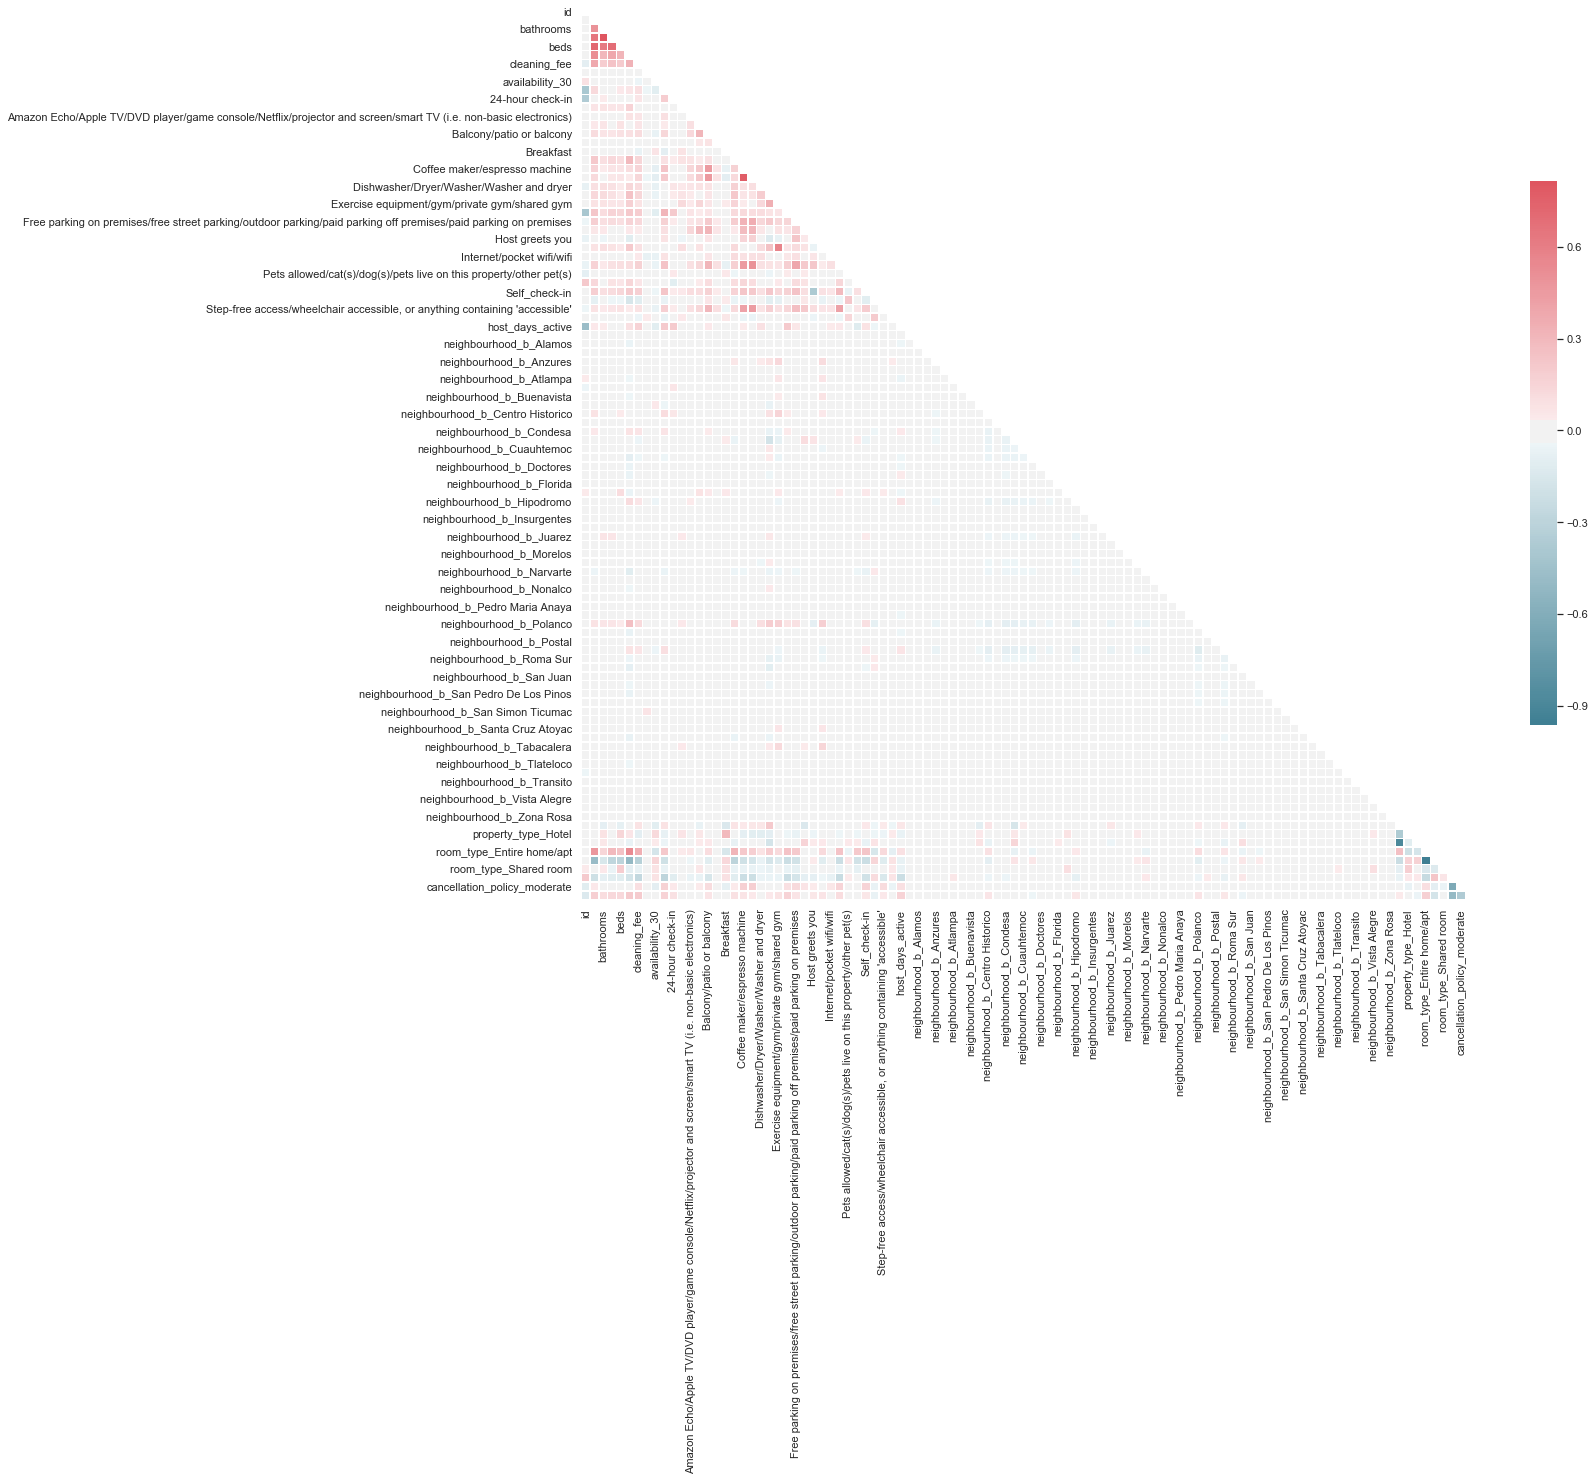

In [9]:
#First collinearity heatmap
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

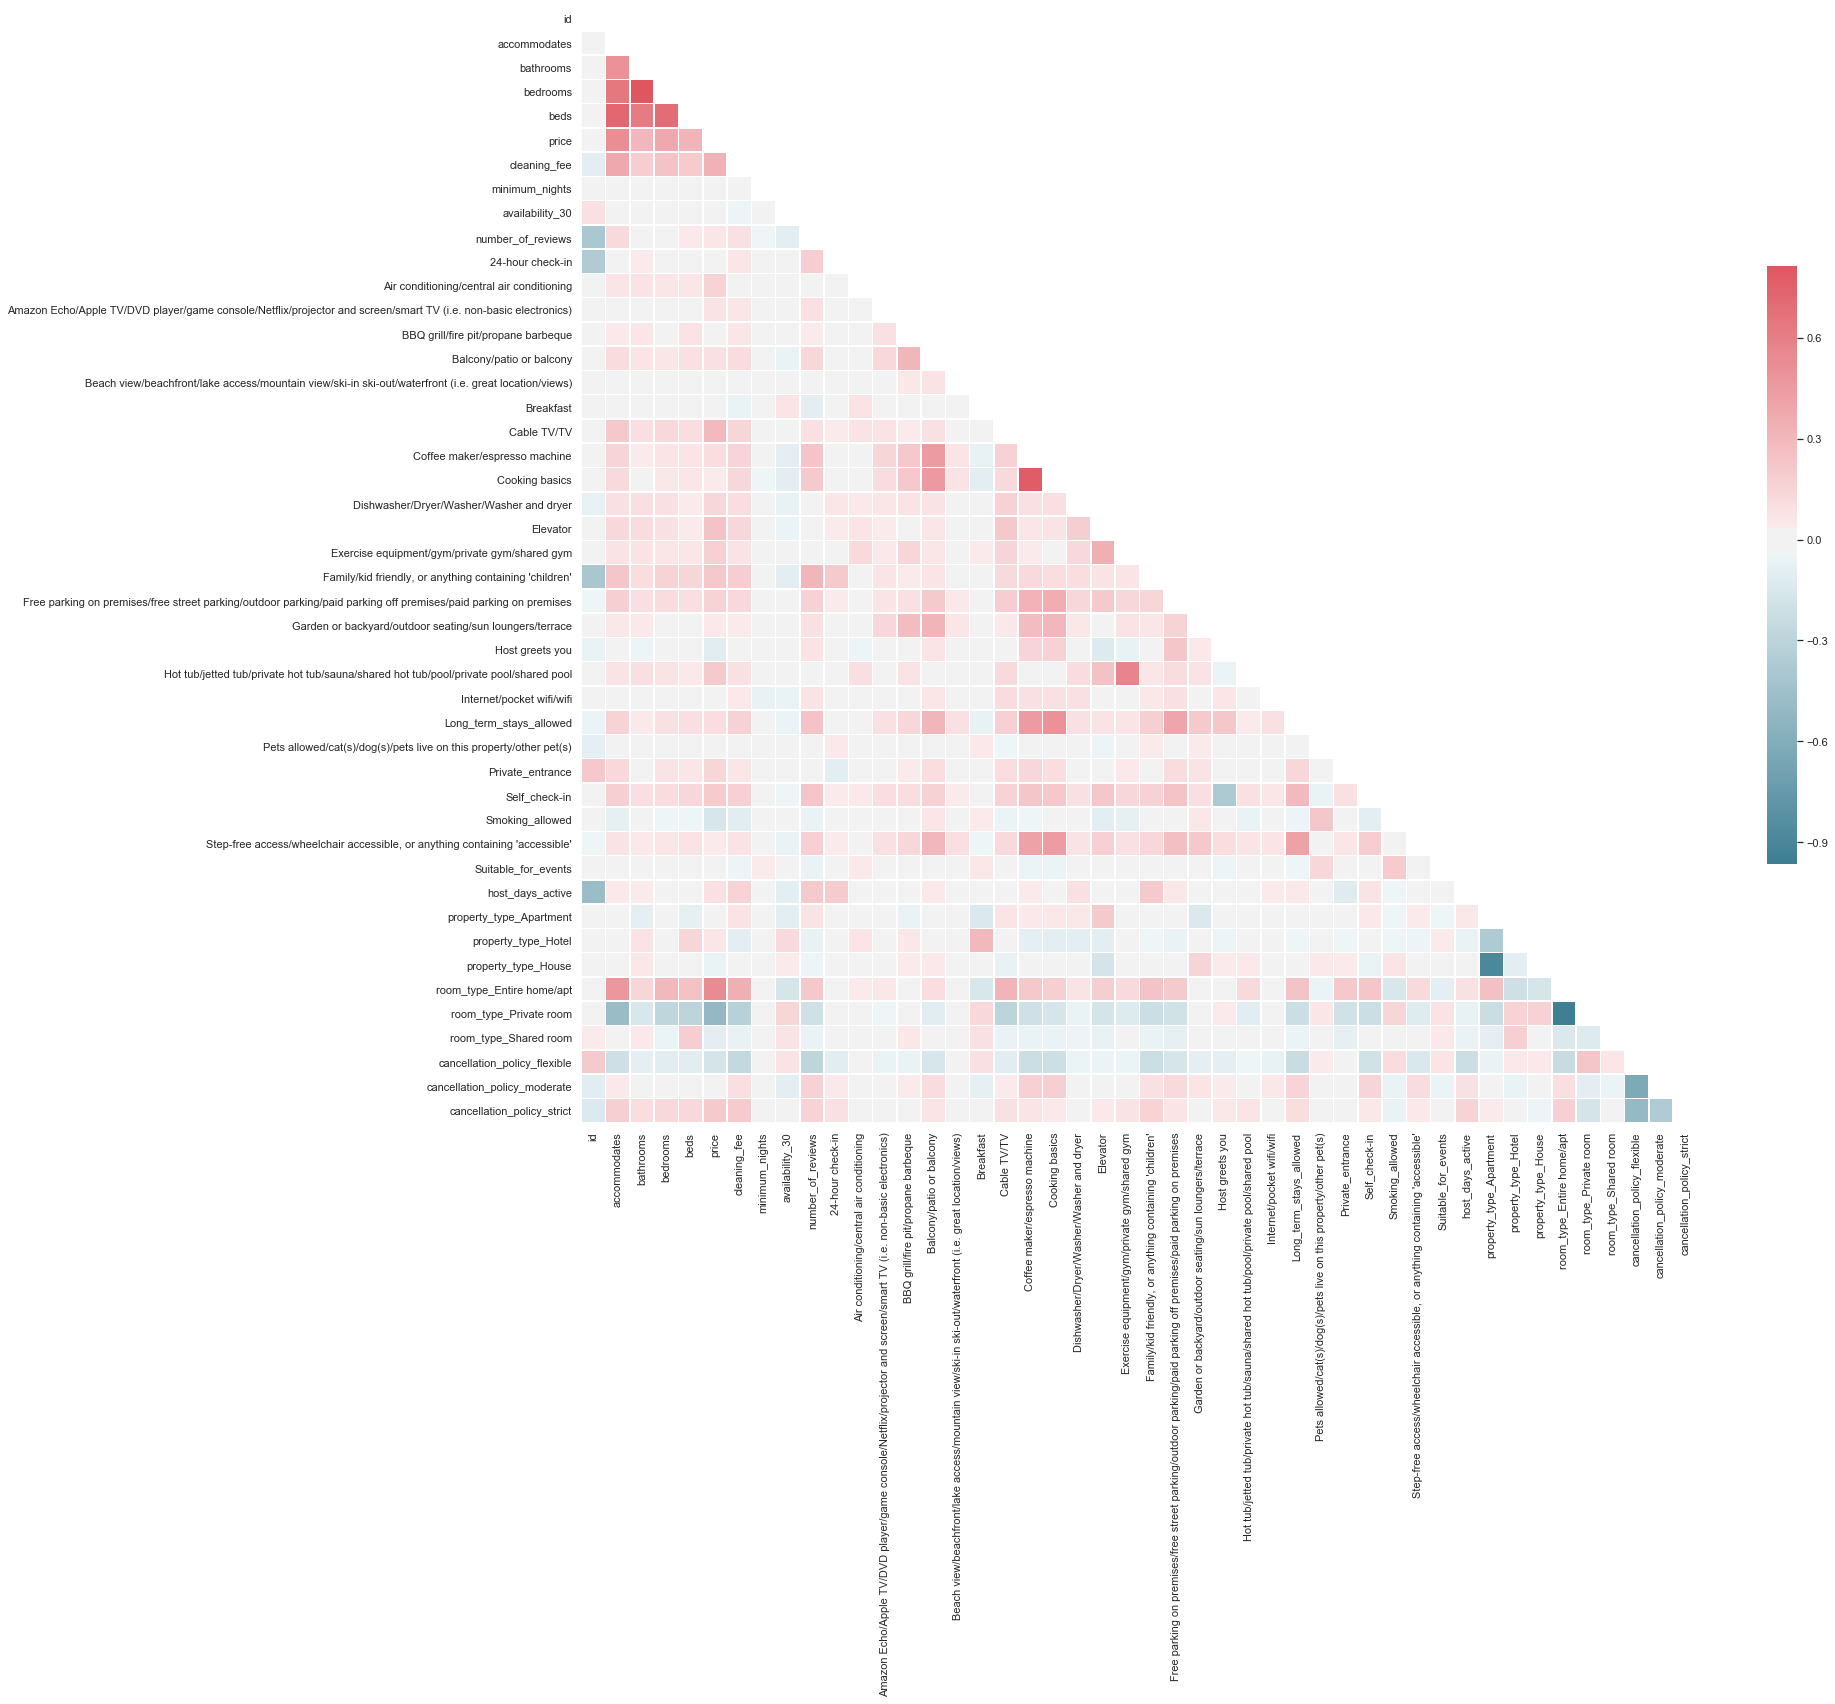

In [10]:
# We eliminate the neighbourhood becasue we see that has no impact in collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood_b')]), axis=1), figsize=(25,22))

In [11]:
#Analisis de colinealidad
#Alta colinealidad

#Colinealidad negativa
#property_type_house vs property_type_apartment
#room_type_private_room vs room_type_entire_home/apt
#menor:
#cancellation_policy_stict vs cancellation_policy_flexible
#cancellation_policy_moderate vs cancellation_policy_flexible

In [12]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'property_type_Apartment',
           'room_type_Private room',
           'Cooking basics']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

In [13]:
#Extracting only numerical data
numerical_columns = ['accommodates', 'bathrooms', 'cleaning_fee', 'minimum_nights','availability_30','number_of_reviews', 'price', 'host_days_active']


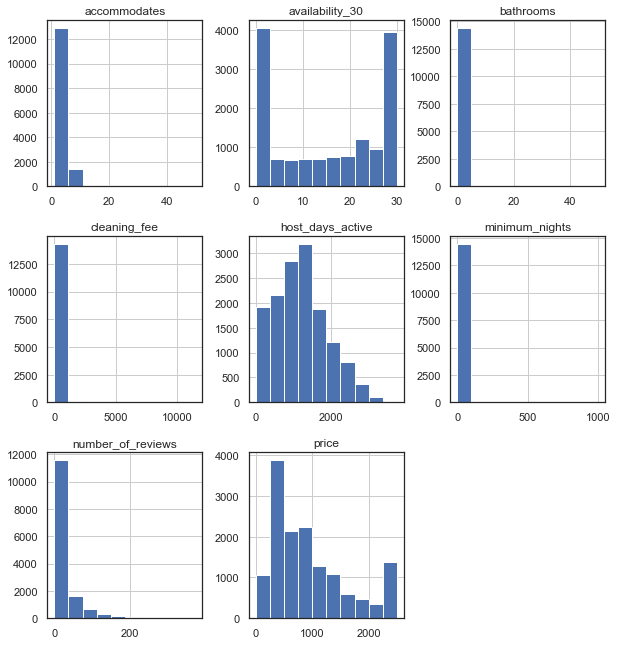

In [14]:
#Plotting the numerical data to analyze it
transformed_df[numerical_columns].hist(figsize=(10,11));

In [15]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_30', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

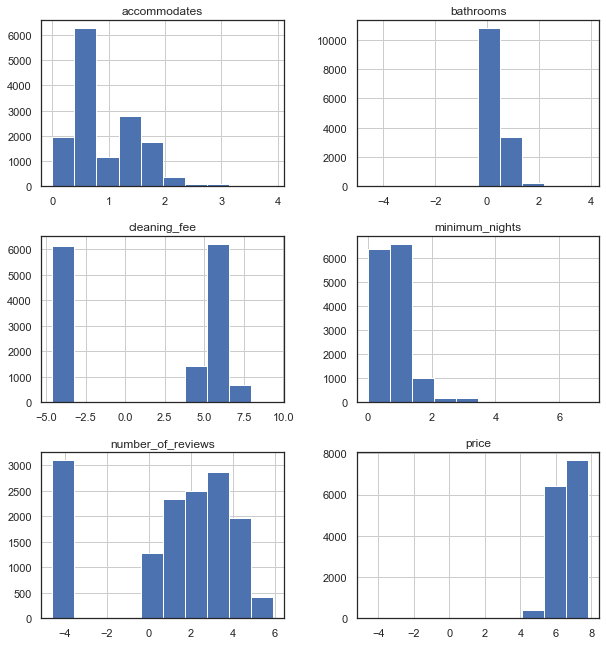

In [16]:
#Plotting the transformed data
transformed_df[numerical_columns].hist(figsize=(10,11));

In [17]:
# Separating X and y data (features and target)
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling Data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [18]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [19]:
# Create a LinearRegression model and fit it to the scaled training data
model = LinearRegression()
model.fit(X_train, y_train)  #Training the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
# Model predictions
predictions = model.predict(X_test) 
#model.fit(X_train, y_train)
#training_score = model.score(X_train, y_train)
#testing_score = model.score(X_test, y_test)
#print(f"Training Score: {training_score}")
#print(f"Testing Score: {testing_score}")

In [21]:
X_test.head()

,id,accommodates,bathrooms,cleaning_fee,minimum_nights,availability_30,number_of_reviews,24-hour check-in,Air conditioning/central air conditioning,Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV (i.e. non-basic electronics),...,neighbourhood_b_Vista Alegre,neighbourhood_b_Xoco,neighbourhood_b_Zona Rosa,property_type_Hotel,property_type_House,room_type_Entire home/apt,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
8630,0.422341,-0.448267,-0.519989,-1.159074,-0.806447,0.508993,1.038146,-0.313647,-0.200352,-0.133183,...,-0.038138,-0.045598,-0.067717,-0.203506,-0.486801,0.965128,-0.138205,1.068233,-0.667433,-0.538466
8523,0.395918,0.749128,1.070574,0.956469,0.148804,-0.340622,0.589317,-0.313647,-0.200352,7.508461,...,-0.038138,-0.045598,-0.067717,-0.203506,-0.486801,0.965128,-0.138205,-0.936125,-0.667433,1.857128
11697,1.032503,-0.448267,-0.519989,0.785356,1.411578,-1.275198,-0.082627,-0.313647,-0.200352,-0.133183,...,-0.038138,-0.045598,-0.067717,-0.203506,-0.486801,-1.036132,-0.138205,1.068233,-0.667433,-0.538466
1935,-1.241806,0.252164,-0.519989,0.703408,0.148804,1.188686,-1.746209,3.188299,-0.200352,-0.133183,...,-0.038138,-0.045598,-0.067717,-0.203506,-0.486801,0.965128,-0.138205,1.068233,-0.667433,-0.538466
4949,-0.364803,-0.448267,-0.519989,0.963338,0.148804,0.848840,0.422709,-0.313647,-0.200352,-0.133183,...,-0.038138,-0.045598,-0.067717,-0.203506,-0.486801,0.965128,-0.138205,-0.936125,-0.667433,1.857128


In [23]:
# To assess the Linear Regression we plot residual values
#plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
#plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
#plt.legend()
#plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
#plt.title("Residual Plot")
#plt.show()

In [26]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.23968199298804385, R2: 0.5700500272445332


In [50]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.01).fit(X_train, y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.24378893021184397, R2: 0.5626674811793693


In [25]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=.01).fit(X_train, y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.23968199298804385, R2: 0.5700349084007856


In [69]:
# Save the model for later use
pickle.dump(model, open(filename, 'wb'))
#Load the model
#load_lr_model = pickle.load(open(Regressor_model.sav, 'rb'))
#Para usarlo:
#y_load_predit=load_lr_model.predict(X_test)